In [1]:
from typing import Any, Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import uncertainty_toolbox as uct

from sklearn.model_selection import train_test_split, GridSearchCV

from src.probabilistic_flow_boosting.extras.datasets.uci_dataset import UCIDataSet
from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed
from src.probabilistic_flow_boosting.tfboost.softtreeflow import SoftTreeFlow

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
RANDOM_SEED = 42

setup_random_seed(RANDOM_SEED)

In [3]:
x_train = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_features.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_train_1.txt"
).load()
y_train = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_target.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_train_1.txt"
).load()

x_test = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_features.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_test_1.txt"
).load()
y_test = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_target.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_test_1.txt"
).load()

In [4]:
def softtreeflow_logprob(model: SoftTreeFlow, X: torch.Tensor, y: torch.Tensor):
    model.eval()
    
    with torch.no_grad():
        result = model.log_prob(X, y).mean().item()
        
    model.train()
    return result


def fit_softtreeflow(
    x_train: np.ndarray, 
    y_train: np.ndarray, 
    param_grid: Dict[str, List[Any]],
    cv: int = 3,
    n_epochs: int = 200, 
    patience: int = 50,
    batch_size: int = 128,
    random_state: int = 42,
    test_size: float = 0.2
):  
    model = SoftTreeFlow(
        input_dim=x_train.shape[1],
        output_dim=y_train.shape[1],
    )
    model.train()
    
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = test_size, random_state=random_state)
    
    grid = GridSearchCV(
        estimator=model,
        scoring=softtreeflow_logprob,
        cv=cv,
        param_grid=param_grid,
        refit=True,
        return_train_score=True
    )

    grid.fit(x_tr, y_tr, X_val=x_val, y_val=y_val, n_epochs=1)
    return grid.best_estimator_, grid.refit_time_

In [5]:
param_grid = {
    "tree_depth": [2, 3, 4, 5]
}


model, fit_time = fit_softtreeflow(
    x_train=x_train.values, 
    y_train=y_train.values,
    param_grid=param_grid
)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


In [6]:
def univariate_probabilistic_regression_report(estimator: SoftTreeFlow, X: np.ndarray, y: np.ndarray, **kwargs) -> Dict[str, float]:
    y_pred: np.ndarray = estimator.predict(X, **kwargs)
    
    metrics = {
        "nll": estimator.nll(X, y),
        "crps": estimator.crps(X, y),
    }
    
    y: np.ndarray = y.squeeze()
    metrics.update(uct.get_all_accuracy_metrics(y_pred=y_pred, y_true=y, verbose=False))
    return metrics

In [7]:
univariate_probabilistic_regression_report(model, x_train.values, y_train.values)

{'nll': 3.1532762,
 'crps': None,
 'mae': 1.5186700297362943,
 'rmse': 1.703531870301145,
 'mdae': 1.1671171188354492,
 'marpd': 24.632154628758705,
 'r2': -3.4275376545244756,
 'corr': -0.03610403751787532}

In [8]:
univariate_probabilistic_regression_report(model, x_test.values, y_test.values)

{'nll': 3.1169887,
 'crps': None,
 'mae': 1.5086489766836166,
 'rmse': 1.6926124821337198,
 'mdae': 1.1611897945404053,
 'marpd': 24.441011069162958,
 'r2': -3.6313707739123986,
 'corr': -0.061307487052600536}

In [9]:
with torch.no_grad():
    model.eval()

    logprob_train = - model.log_prob(x_train.values, y_train.values, batch_size=2000).mean()
    logprob_test = - model.log_prob(x_test.values, y_test.values, batch_size=2000).mean()

    print(logprob_train.item(), logprob_test.item())

3.150172710418701 3.1091949939727783


In [10]:
with torch.no_grad():
    model.eval()

    logprob_train = - model.log_prob(x_train.values, y_train.values, batch_size=2000).mean()
    logprob_test = - model.log_prob(x_test.values, y_test.values, batch_size=2000).mean()

    print(logprob_train.item(), logprob_test.item())

3.154658555984497 3.1167030334472656


In [11]:
y_test_samples = model.sample(x_test.values, num_samples = 1000, batch_size = 2000)

In [12]:
y_test_samples.shape

(160, 1000)

In [13]:
paths = model.predict_tree_path(x_test.values)

In [14]:
paths.shape

(160, 16)

Sample 0, paths probability:
         0
2  0.62875
14 0.19590
3  0.08308
5  0.05505
7  0.02423


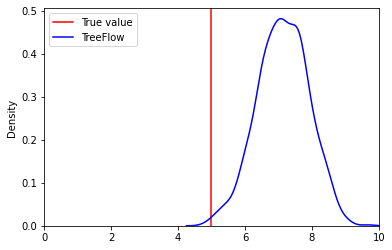

Sample 1, paths probability:
         0
2  0.58437
14 0.26080
3  0.11274
5  0.01831
4  0.00944


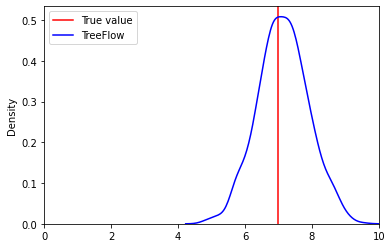

Sample 2, paths probability:
         0
2  0.57627
14 0.22318
3  0.14679
5  0.01611
4  0.01388


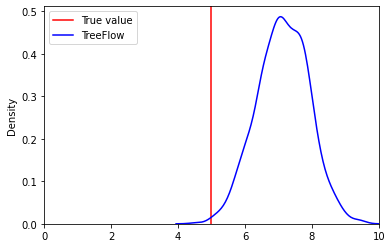

Sample 3, paths probability:
         0
2  0.63054
14 0.27352
3  0.07806
5  0.01332
7  0.00219


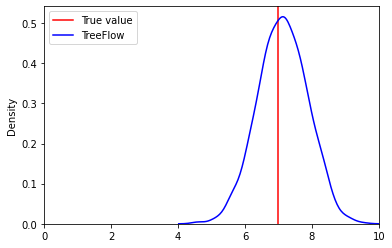

Sample 4, paths probability:
         0
2  0.59850
14 0.36003
3  0.03159
5  0.00849
7  0.00123


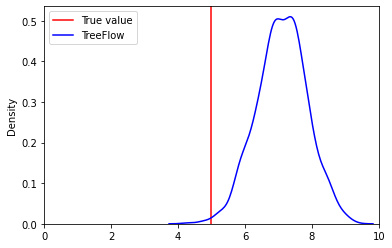

Sample 5, paths probability:
         0
2  0.68907
14 0.27397
5  0.01947
3  0.01209
7  0.00538


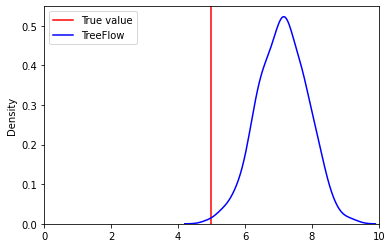

Sample 6, paths probability:
         0
2  0.69425
14 0.24062
3  0.03067
5  0.02546
7  0.00873


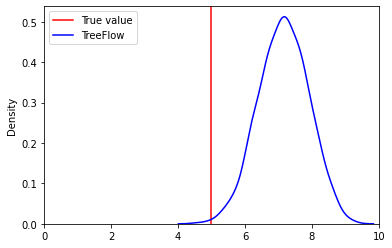

Sample 7, paths probability:
         0
2  0.64628
14 0.32264
3  0.02329
5  0.00731
7  0.00040


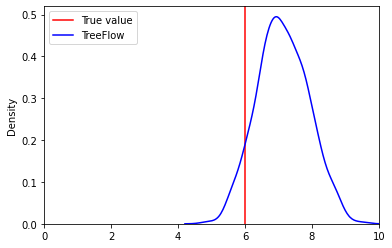

Sample 8, paths probability:
         0
2  0.64279
14 0.23315
3  0.09016
5  0.02282
4  0.00380


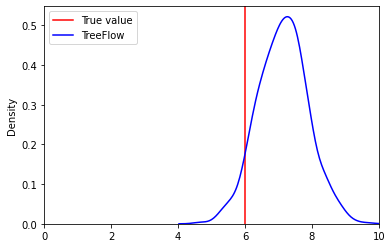

Sample 9, paths probability:
         0
2  0.82282
14 0.14382
5  0.02293
7  0.00661
3  0.00382


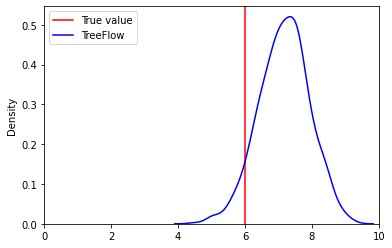

Sample 10, paths probability:
         0
2  0.64847
14 0.33935
5  0.00612
7  0.00536
3  0.00070


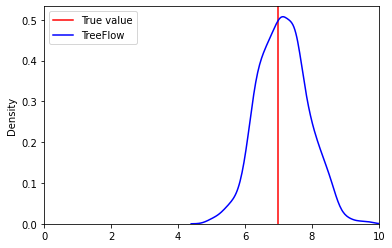

Sample 11, paths probability:
         0
2  0.70427
14 0.28041
7  0.00874
5  0.00651
3  0.00006


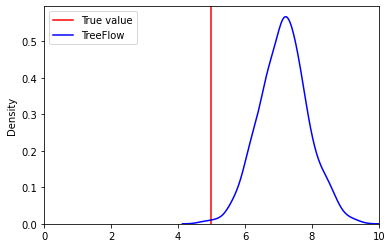

Sample 12, paths probability:
         0
2  0.57310
14 0.19577
3  0.12669
5  0.04059
4  0.01939


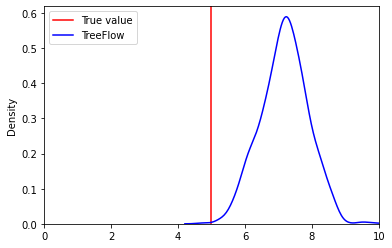

Sample 13, paths probability:
         0
2  0.65633
14 0.13291
5  0.08772
7  0.06520
3  0.04215


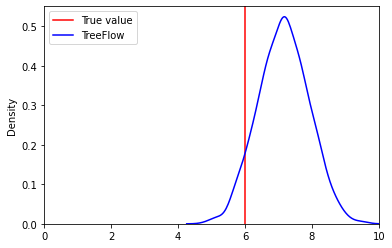

Sample 14, paths probability:
         0
2  0.53386
14 0.45367
3  0.00923
5  0.00301
7  0.00023


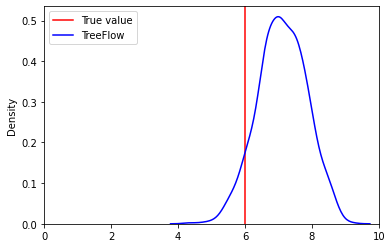

Sample 15, paths probability:
         0
2  0.60895
14 0.25282
3  0.09579
5  0.02618
7  0.00678


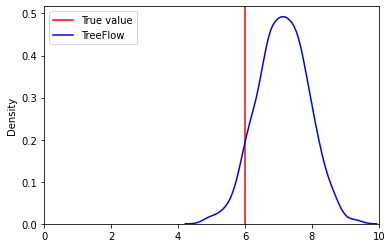

Sample 16, paths probability:
         0
2  0.64401
14 0.20965
3  0.06484
5  0.05228
7  0.02089


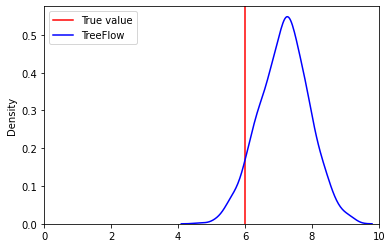

Sample 17, paths probability:
         0
2  0.79337
14 0.09862
5  0.06151
7  0.03897
3  0.00729


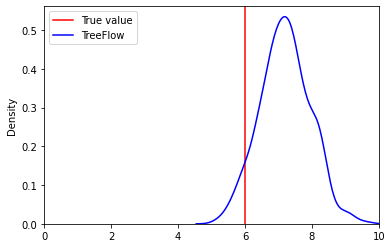

Sample 18, paths probability:
         0
2  0.66236
14 0.13780
3  0.10131
5  0.05583
7  0.01634


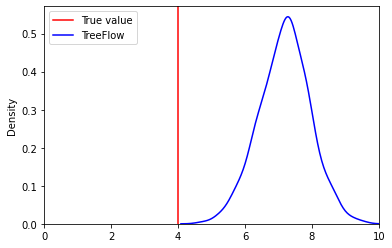

Sample 19, paths probability:
         0
2  0.71590
14 0.14319
7  0.13048
5  0.01034
3  0.00009


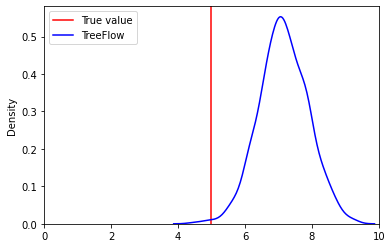

Sample 20, paths probability:
         0
2  0.71847
14 0.20167
3  0.03862
5  0.03292
7  0.00763


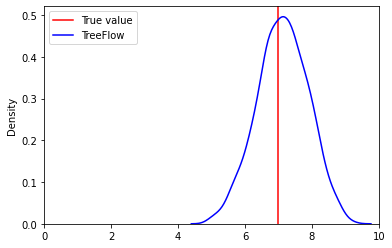

Sample 21, paths probability:
         0
2  0.61239
14 0.25948
3  0.09153
5  0.02369
7  0.00490


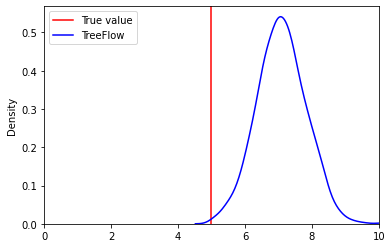

Sample 22, paths probability:
         0
2  0.69140
14 0.17433
7  0.05859
5  0.05145
3  0.02254


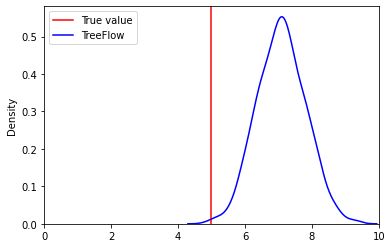

Sample 23, paths probability:
         0
2  0.63542
14 0.14953
3  0.13420
5  0.02473
4  0.01971


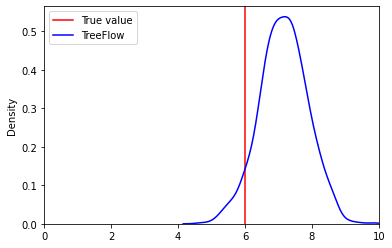

Sample 24, paths probability:
         0
7  0.55205
2  0.35052
14 0.09629
5  0.00114
3  0.00000


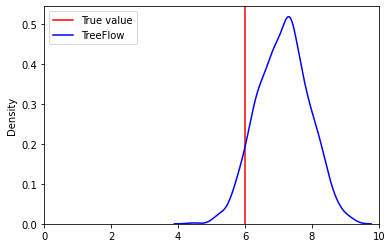

Sample 25, paths probability:
         0
2  0.63785
14 0.25566
7  0.06331
5  0.02652
3  0.01589


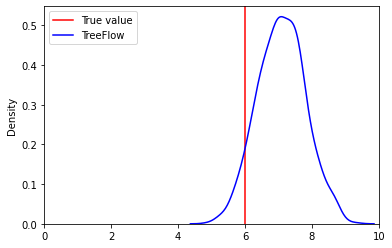

Sample 26, paths probability:
         0
2  0.69980
14 0.27442
5  0.01242
3  0.00898
7  0.00437


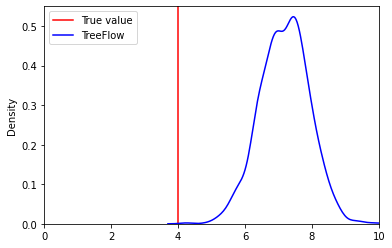

Sample 27, paths probability:
         0
2  0.62266
14 0.29641
3  0.05103
5  0.02278
7  0.00578


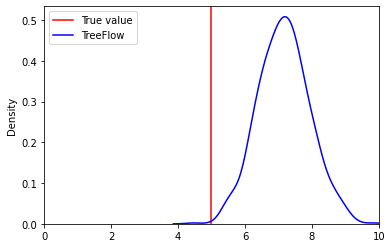

Sample 28, paths probability:
         0
2  0.44923
14 0.29841
3  0.17495
5  0.01949
7  0.01459


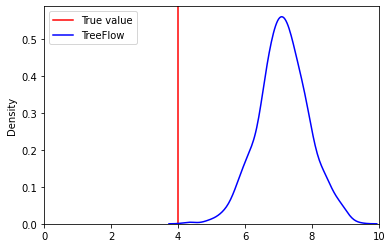

Sample 29, paths probability:
         0
2  0.55152
14 0.27986
3  0.10410
5  0.02896
7  0.02349


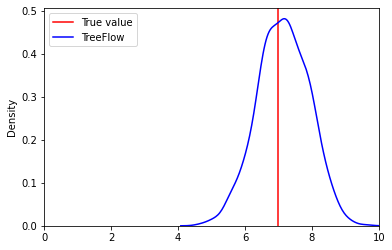

In [15]:
for i in range(30):
    print(f"Sample {i}, paths probability:")
    print(pd.DataFrame(paths[i, :]).sort_values(0, ascending=False).head(5))
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    ## TreeFlow
    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    plt.xlim([0, 10])
    plt.legend()
    plt.show()
    plt.close()